In [1]:
import os
import numpy as np
import pandas as pd
import skimage.io
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#from https://www.kaggle.com/mpware/ensembling-on-instance-segmentation-lb-0-419

In [2]:
#STAGE1_TEST = "./samples/nucleus/datasets/nucleus/stage2_test" 
#STAGE1_TEST_IMAGE_PATTERN = "%s/{}/images/{}.png" % STAGE1_TEST
#SUBMISSION_IMAGEID = "ImageId"
#SUBMISSION_ENCODED = "EncodedPixels"
#models_path = [
#    "./Submissions/submit_imagenet_test_and_training.csv",
#    "./Submissions/submit_mask_coco.csv",
#    "./Submissions/submit_mask_imagenet_training.csv"
#]

STAGE1_TEST = ".\\samples\\nucleus\\datasets\\nucleus\\stage2_test" 
STAGE1_TEST_IMAGE_PATTERN = "%s\\{}\\images\\{}.png" % STAGE1_TEST
SUBMISSION_IMAGEID = "ImageId"
SUBMISSION_ENCODED = "EncodedPixels"
models_path = [
#    "./Submissions/submit_imagenet_test_and_training.csv",
#    "./Submissions/submit_mask_coco.csv",
#    "./Submissions/submit_mask_imagenet_training.csv"

#    ".\\Submissions\\submit_mask_coco.csv",
    ".\\Submissions\\submit_coco_training.csv",
    ".\\Submissions\\submit_coco_training_and_testing.csv"
]

In [3]:
# Image loading
def image_ids_in(root_dir):
    ids = []
    for id in os.listdir(root_dir):
        ids.append(id)
    return ids

def read_image(image_id, pattern=STAGE1_TEST_IMAGE_PATTERN):
    image_file = pattern.format(image_id, image_id)
    image = skimage.io.imread(image_file)
    # Drop alpha which is not used
    if(len(image.shape)==3):
        image = image[:, :, :3]

    return image

def image_id_to_index(image_id, images_ids):
    i = np.argwhere(np.array(images_ids) == image_id)[0][0]
    return i

In [4]:
# RLE decoding functions
def rle_decode_one_mask(rle_str, mask_shape, mask_dtype):
    s = rle_str.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(np.prod(mask_shape), dtype=mask_dtype)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = 1
    return mask.reshape(mask_shape[::-1]).T

def rle_decode_all_masks(masks_str, mask_shape, mask_dtype):
    image = None
    i = 0
    for mask_str in masks_str:
        i = i + 1
        mask = rle_decode_one_mask(mask_str, mask_shape, mask_dtype)
        mask[mask == 1] = i
        if image is None:
            image = mask
        else:
            image = image + mask
    return image

In [5]:
# Test images
test_image_ids = image_ids_in(STAGE1_TEST)


In [6]:
# Convert index image (unique value per mask) to array.
def img_masks_as_masks_array(train_label):
    # As (masks, height, width)
    y_true = []
    uniques = np.unique(train_label)
    # Remove zero from index
    indexes = np.delete(uniques, np.where(uniques == 0))
    for index in indexes:
        y_true.append(np.where(train_label == index, 1, 0))
    y_true = np.array(y_true)
    return y_true

# Convert back all mask to index image
def masks_array_to_index_image(masks):
    mask = np.zeros((masks.shape[1], masks.shape[2]), dtype=np.uint16)
    for index in range(0, masks.shape[0]):
        mask[masks[index,:,:] > 0] = index + 1
    return mask

# Read image and predicted masks
def read_test_image_mask(submissionPD, test_id):
    test_image = read_image(test_id)
    rle_encoded_masks = submissionPD[submissionPD[SUBMISSION_IMAGEID] == test_id][SUBMISSION_ENCODED].values
    test_masks = rle_decode_all_masks(rle_encoded_masks, test_image.shape[:-1], np.int32)
    test_masks_array = img_masks_as_masks_array(test_masks)
    return test_image, test_masks_array

In [7]:
# Extract bounding box of mask
def find_bounding_boxes_on_mask(bin_img, test_id, mask_id, with_ref=None):
    boxes = []
    img_bin = np.where(bin_img > 0, 1, 0)
    img_rgb = (img_bin)*255
    img_rgb = np.concatenate([img_rgb[:, :, np.newaxis], img_rgb[:, :, np.newaxis], img_rgb[:, :, np.newaxis]], axis=-1)
    img_rgb = img_rgb.astype(np.uint8)
    im_bw = cv2.cvtColor(img_rgb,cv2.COLOR_RGB2GRAY)
    ret, im_bw = cv2.threshold(im_bw, 127, 255, cv2.THRESH_BINARY)
    pixelpoints = cv2.findNonZero(im_bw)
    x, y, w, h = cv2.boundingRect(pixelpoints)
    if with_ref is not None:
        boxes.append((x, y, w, h, with_ref, test_id, mask_id))
    else:
        boxes.append((x,y,w,h))
    return np.array(boxes)

In [8]:
# Extract all bounding boxes
def find_bounding_boxes_on_masks(test_masks_array, test_id, with_ref=None):
    test_masks_pass = []
    boxes_masks = []
    for mask_id in range(0, len(test_masks_array)):
        mask = test_masks_array[mask_id]
        if(type(mask)==np.int32):
            mask = np.array([[mask,mask],[mask,mask],[mask,mask]])
        boxes = find_bounding_boxes_on_mask(mask, test_id, mask_id, with_ref=with_ref)
        boxes_masks.append(boxes)
        test_masks_pass.append(mask)
    test_masks_pass = np.array(test_masks_pass)
    boxes_masks = np.array(boxes_masks)
    return test_masks_pass, boxes_masks

In [9]:
# Image and array of masks + bounding boxes for each model (for a given image).
def models_cv_masks_for_image(models_path, test_id, test_image_ids):
    test_id_ref = image_id_to_index(test_id, test_image_ids)
    models_cv_masks = []
    models_cv_masks_boxes = []
    for i in range(0, len(models_path)):
        model_path = models_path[i]
        submission = pd.read_csv(model_path)
        submission.dropna(subset=[SUBMISSION_ENCODED], inplace=True)
        test_image, test_masks_array = read_test_image_mask(submission, test_id)
        test_masks_clean, boxes_masks = find_bounding_boxes_on_masks(test_masks_array, test_id_ref, with_ref=i)
        models_cv_masks.append(test_masks_clean)
        models_cv_masks_boxes.append(boxes_masks)
    return test_image, models_cv_masks, models_cv_masks_boxes

In [10]:
# Basic NMS on boxes, https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding box and the smallest (x, y) coordinates for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the integer data type
    return boxes[pick].astype("int")

In [11]:
# Compute NMS (i.e. select only one box when multiple boxes overlap) for across models.
def models_cv_masks_boxes_nms(models_cv_masks_boxes, threshold=0.3):
    #boxes_nms = []
    #test = lambda x: len(set(map(len, x))) == 1
    #if(test(models_cv_masks_boxes)):
    boxes = np.concatenate(models_cv_masks_boxes).squeeze()
    boxes_nms = non_max_suppression_fast(boxes, threshold)
    return boxes_nms

In [12]:
# Display some result (on the nightmare images)
# test_id = "0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466"
test_id = "00ac87390253a22f6eb67c5771a73050e06200d1aa682fcf1b1e3783b2944166"

In [13]:
# Get masks and boxes (one per mask) for each model
test_image, test_masks_cv_array, test_masks_boxes_cv_array = models_cv_masks_for_image(models_path, test_id, test_image_ids)

In [14]:
# Run NMS ensembling
masks_boxes_nms = models_cv_masks_boxes_nms(test_masks_boxes_cv_array, threshold=0.3)

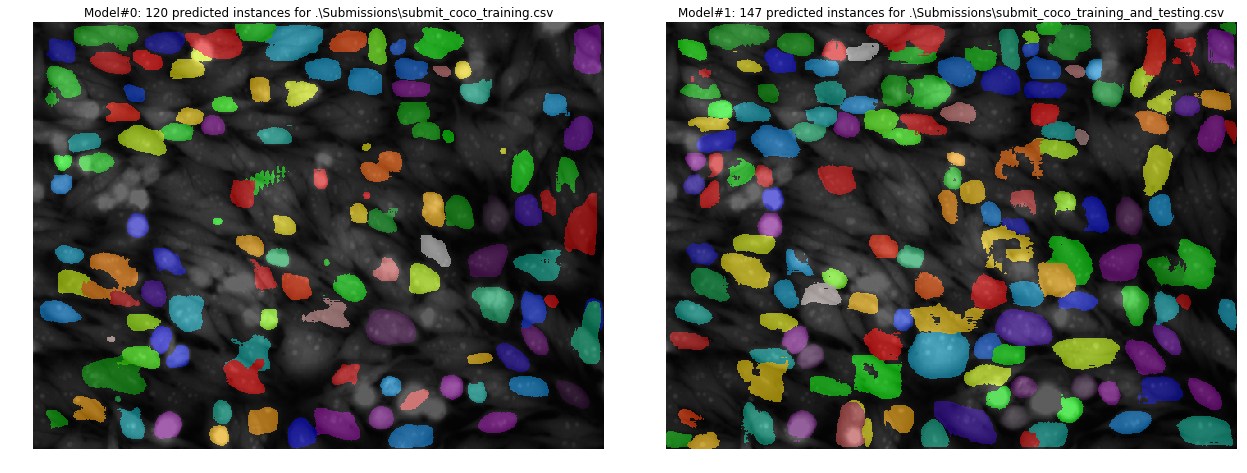

In [15]:
# Plot predictions of each model
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].axis('off')
ax[0].imshow(masks_array_to_index_image(test_masks_cv_array[0]), cmap='nipy_spectral')
ax[0].imshow(test_image, alpha=0.45)
ax[0].set_title("Model#0: %d predicted instances for %s"%(len(test_masks_cv_array[0]), models_path[0]))

ax[1].axis('off')
ax[1].imshow(masks_array_to_index_image(test_masks_cv_array[1]), cmap='nipy_spectral')
ax[1].imshow(test_image, alpha=0.45)
ax[1].set_title("Model#1: %d predicted instances for %s"%(len(test_masks_cv_array[1]), models_path[1]))

plt.tight_layout()

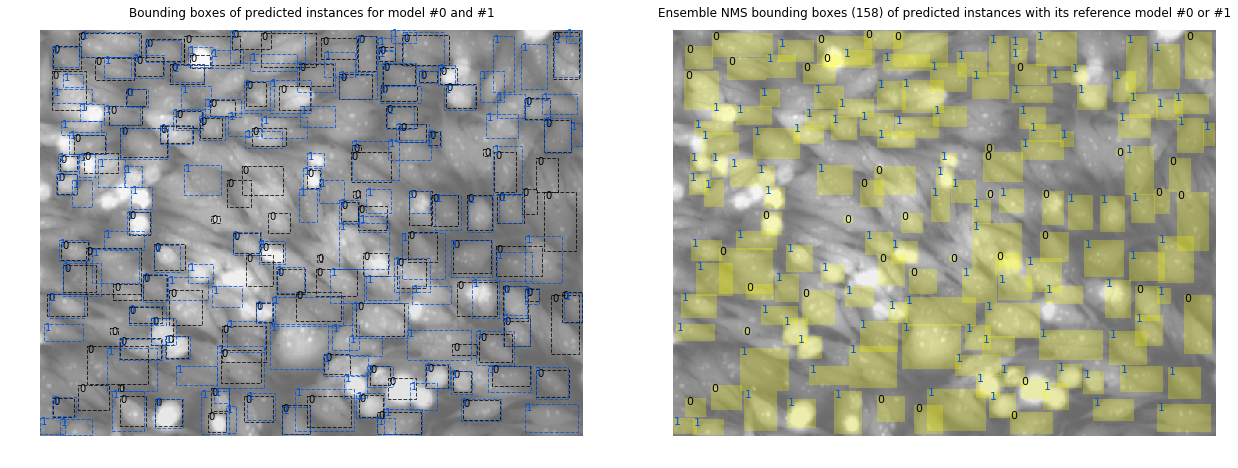

In [16]:
# Plot boxes for each model (left) and resulting NMS (right)
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].axis('off')
ax[0].set_ylim(test_image.shape[0] + 10, -10)
ax[0].set_xlim(-10, test_image.shape[1] + 10)
cmap = plt.cm.get_cmap('nipy_spectral')
# Plot boxes per model
for box in np.concatenate(test_masks_boxes_cv_array).squeeze():
    p = patches.Rectangle((box[0]-1, box[1]-1), box[2], box[3], linewidth=1, facecolor='none', edgecolor=cmap(box[4]*60), alpha=0.75, linestyle="dashed")
    ax[0].add_patch(p)
    ax[0].text(box[0], box[1] + 8, "%d"%box[4], color=cmap(box[4]*60), size=10, backgroundcolor="none") 
ax[0].imshow(test_image, alpha=0.6)
ax[0].set_title("Bounding boxes of predicted instances for model #0 and #1")

# Plot NMS results
ax[1].set_ylim(test_image.shape[0] + 10, -10)
ax[1].set_xlim(-10, test_image.shape[1] + 10)
ax[1].axis('off')
for box_nms in masks_boxes_nms:
    p = patches.Rectangle((box_nms[0]-1, box_nms[1]-1), box_nms[2], box_nms[3], linewidth=1, facecolor='yellow', alpha=0.25, linestyle="dashed")
    ax[1].add_patch(p)
    ax[1].text(box_nms[0], box_nms[1] + 8, "%d"%box_nms[4], color=cmap(box_nms[4]*60), size=11, backgroundcolor="none")  
ax[1].imshow(test_image, alpha=0.6)
ax[1].set_title("Ensemble NMS bounding boxes (%d) of predicted instances with its reference model #0 or #1"%len(masks_boxes_nms))
plt.tight_layout()

In [17]:
# Back to masks from NMS boxes

def get_masks_from_boxes_nms(masks_boxes_nms, test_masks_cv_array):
    masks_nms = []
    for box_nms in masks_boxes_nms:
        model_id = box_nms[4]
        mask_id = box_nms[6]
        mask_nms = test_masks_cv_array[model_id][mask_id]
        masks_nms.append(mask_nms)
    masks_nms = np.array(masks_nms)
    return masks_nms

In [18]:
# NMS instances
masks_nms = get_masks_from_boxes_nms(masks_boxes_nms, test_masks_cv_array)


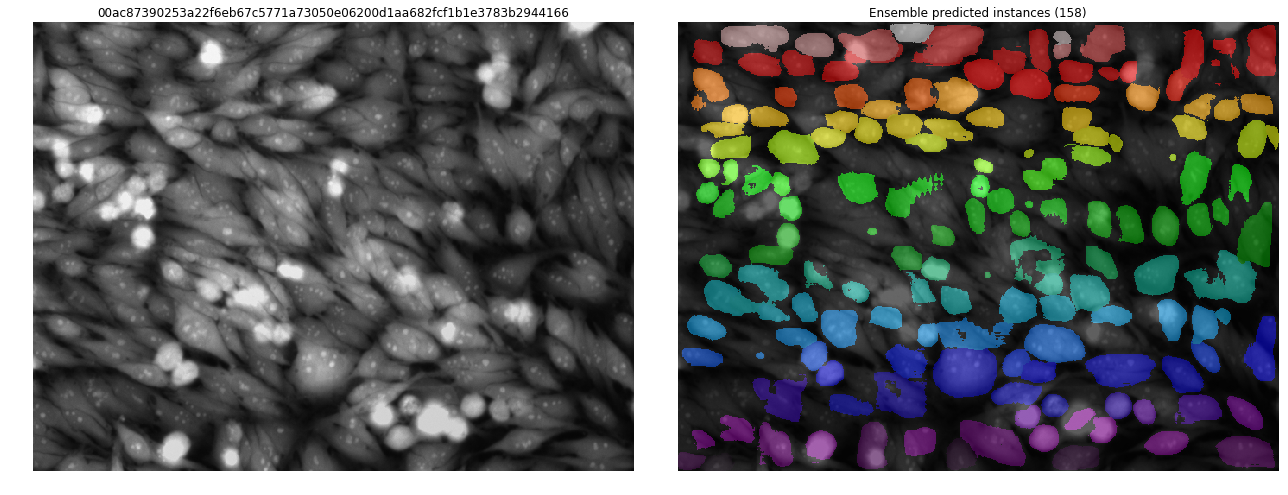

In [19]:
# Plot masks from NMS boxes
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].axis('off')
masks_nms_image = masks_array_to_index_image(masks_nms)
ax[0].imshow(test_image)
ax[0].set_title("%s"%test_id)
ax[1].axis('off')
ax[1].imshow(masks_nms_image, cmap='nipy_spectral')
ax[1].imshow(test_image, alpha=0.45)
ax[1].set_title("Ensemble predicted instances (%d)"%len(masks_nms))
plt.tight_layout()

In [20]:
# RLE encoder
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.T.flatten()
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle

def rle_encode_all_masks(masks):
    values=list(np.unique(masks))
    RLEs=[]
    if(0 in values):
        values.remove(0)
    for v in values:
        mask = np.where(masks == v, 1, 0)
        rle = rle_encode_one_mask(mask)
        rle_str = rle_to_string(rle)
        RLEs.append(rle_str)
    return RLEs

In [21]:
# Generate submission from NMS
def generate_test_submission(image_ids, models_path):
    results = []
    for image_id in image_ids:
        test_image, test_masks_cv_array, test_masks_boxes_cv_array = models_cv_masks_for_image(models_path, image_id, image_ids)
        masks_boxes_nms = models_cv_masks_boxes_nms(test_masks_boxes_cv_array, threshold=0.3)
        returned_masks = get_masks_from_boxes_nms(masks_boxes_nms, test_masks_cv_array)
        if(len(returned_masks.shape)==3):            
            masks_nms = masks_array_to_index_image(returned_masks)
            rle_encoded_masks = rle_encode_all_masks(masks_nms)
            for rle_encoded_mask in rle_encoded_masks:
                info = (image_id, rle_encoded_mask)
                results.append(info)
    df = pd.DataFrame(results, columns=[SUBMISSION_IMAGEID, SUBMISSION_ENCODED])
    return df

In [22]:
submissionPD = generate_test_submission(test_image_ids, models_path)
submissionPD.head()

ValueError: all the input arrays must have same number of dimensions

In [ ]:
submissionPD.to_csv("submission.csv", index=False, sep=",")